# Deep Kernel Learning Classification

## Imports

In [1]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gpytorch.mlls import VariationalELBO
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import (  # BaseModel,; DeterministicGaussianModel,
    DKLClassification,
    DKLGPLayer,
)
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_two_moons_data,
    plot_training_metrics,
)

In [2]:
seed_everything(2)

Seed set to 2


2

In [3]:
# temporary directory for saving
my_temp_dir = tempfile.mkdtemp()

In [4]:
dm = TwoMoonsDataModule(batch_size=100)

In [5]:
# define data
X_train, y_train, X_test, y_test, test_grid_points = (
    dm.X_train,
    dm.y_train,
    dm.X_test,
    dm.y_test,
    dm.test_grid_points,
)

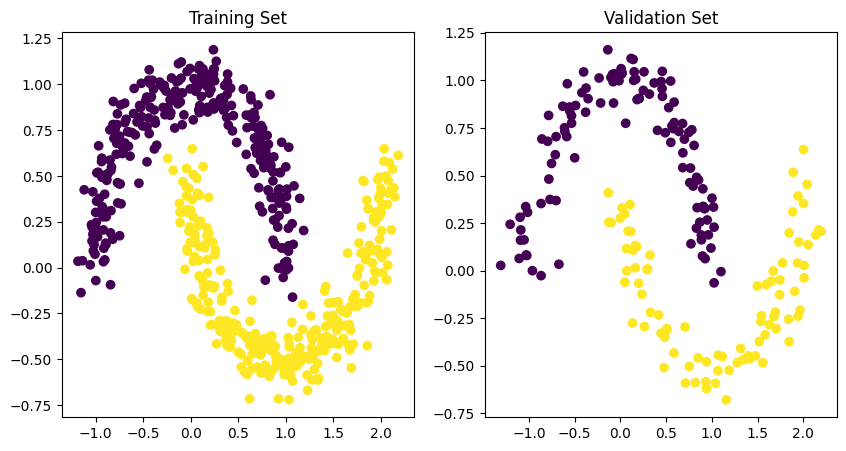

In [6]:
plot_two_moons_data(X_train, y_train, X_test, y_test)

## Feature Extractor

In [7]:
feature_extractor = MLP(
    n_inputs=2, n_outputs=13, n_hidden=[50], activation_fn=torch.nn.ELU()
)

## Deep Kernel Learning Model

In [9]:
dkl_model = DKLClassification(
    feature_extractor,
    gp_kernel="RBF",
    num_classes=2,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    n_inducing_points=100,
)

## Trainer

In [10]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(dkl_model, dm)

Missing logger folder: /tmp/tmpw02zo1h1/lightning_logs

  | Name              | Type              | Params
--------------------------------------------------------
0 | feature_extractor | MLP               | 813   
1 | train_metrics     | MetricCollection  | 0     
2 | val_metrics       | MetricCollection  | 0     
3 | test_metrics      | MetricCollection  | 0     
4 | gp_layer          | DKLGPLayer        | 132 K 
5 | scale_to_bounds   | ScaleToBounds     | 0     
6 | likelihood        | SoftmaxLikelihood | 26    
7 | elbo_fn           | VariationalELBO   | 132 K 
--------------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.534     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

## Training Metrics

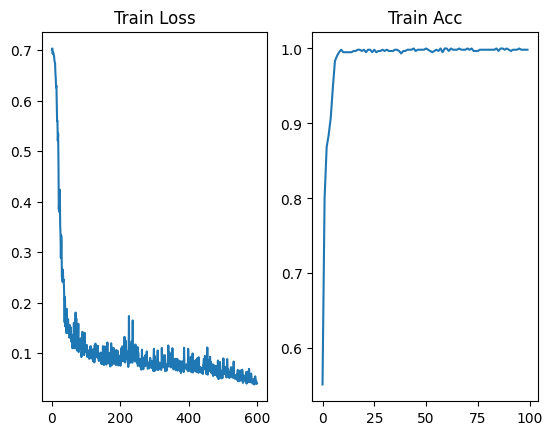

In [12]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "Acc")

## Prediction

In [13]:
# save predictions
trainer.test(dkl_model, dm.test_dataloader())

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          testAcc          │            1.0            │
│        testF1Score        │            1.0            │
│         test_loss         │    0.05357053130865097    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.05357053130865097, 'testAcc': 1.0, 'testF1Score': 1.0}]

## Evaluate Predictions